In [ ]:
# Step 1: Install and Setup Kaggle API
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"enter_username","key":"enter_key"}

import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

# Download FER2013 Dataset
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

# Extract and Organize Dataset
!unzip /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
!tar -xzf /content/fer2013.tar.gz
!mkdir dataset
!mkdir dataset/fer2013
!mv /content/fer2013/fer2013.csv /content/dataset/fer2013
!rm -rf /content/fer2013 /content/fer2013.tar.gz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 kB 4.2 MB/s eta 0:00:00
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17
Archive:  /content/challenges-in-representation-learning-facial-expression-recognition-challenge.zip
  inflating: example_submission.csv  
  inflating: fer2013.tar.gz          
  inflating: icml_face_data.csv      
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
import pandas as pd
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
!ls


 challenges-in-representation-learning-facial-expression-recognition-challenge.zip
 dataset
 example_submission.csv
'happy (1).jpg'
 happy.jpg
 icml_face_data.csv
 sample_data
 test.csv
 train.csv


In [ ]:
class dataset_provider(object):
    def __init__(self, dataset_name, image_size):
        self.dataset_name = dataset_name
        self.image_size = image_size
        self.dataset_path = './dataset/fer2013/fer2013.csv'

    def dataset_initializer(self):
        data = pd.read_csv(self.dataset_path)
        pixels = data['pixels'].tolist()
        width = 48
        height = 48
        faces = []
        for pixel_sequence in pixels:
            face = [int(pixel) for pixel in pixel_sequence.split(' ')]
            face = np.asarray(face).reshape(width, height)
            face = cv2.resize(face.astype('uint8'), self.image_size)
            faces.append(face.astype('float32'))
        faces = np.asarray(faces)
        faces = np.expand_dims(faces, -1)
        emotions = pd.get_dummies(data['emotion']).values
        return faces, emotions

def get_labels(dataset_name):
    if dataset_name == 'fer2013':
        return {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
    else:
        raise Exception('Invalid args: Wrong dataset name.')


def get_class_to_arg(dataset_name):
    if dataset_name == 'fer2013':
        return {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}
    else:
        raise Exception('Invalid args: Wrong dataset name.')


def pre_process(x, _is=True):
    x = x.astype('float32')
    x = x / 255.0
    if _is:
        x = x - 0.5
        x = x * 2.0
    return x

In [ ]:
data = pd.read_csv('./dataset/fer2013/fer2013.csv')
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


In [ ]:
get_labels('fer2013')


{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'sad',
 5: 'surprise',
 6: 'neutral'}

In [ ]:
pd.get_dummies(data['emotion'])


,0,1,2,3,4,5,6
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False
3,False,False,False,False,True,False,False
4,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...
35882,False,False,False,False,False,False,True
35883,False,False,False,True,False,False,False
35884,True,False,False,False,False,False,False
35885,False,False,False,True,False,False,False


In [ ]:

input_shape = (64, 64, 1)
dataset = dataset_provider('fer2013', image_size=input_shape[:2])
faces, emotions = dataset.dataset_initializer()
faces = pre_process(faces)
n_train = int(0.8 * len(faces))
n_test = len(faces) - n_train
ds_train_faces= faces[:n_train]
ds_train_emotions=emotions[:n_train]
ds_test_faces=faces[n_train:]
ds_test_emotions=emotions[n_train:]
val_data=(ds_test_faces,ds_test_emotions)

In [ ]:
ds_train_faces[0]
ds_train_faces[0].shape

(64, 64, 1)

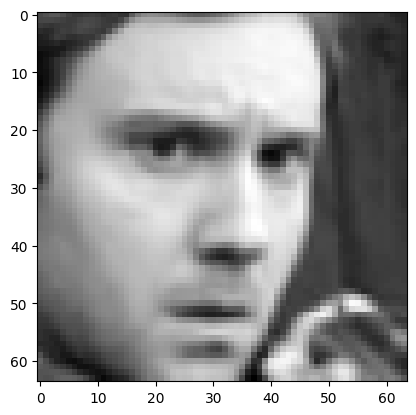

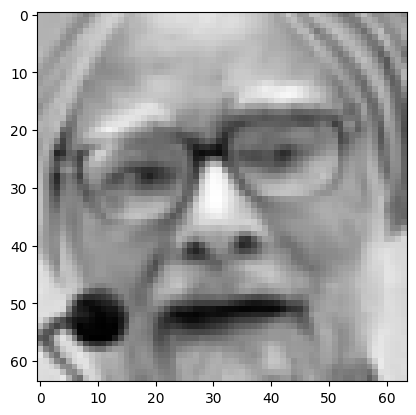

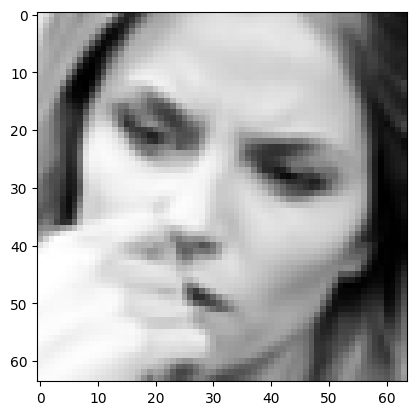

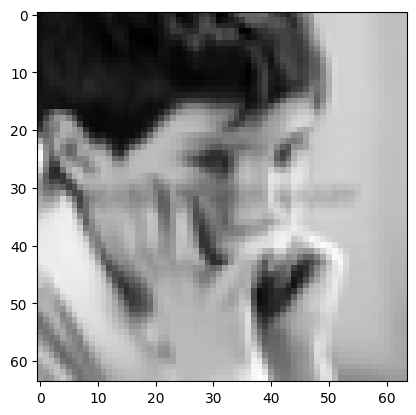

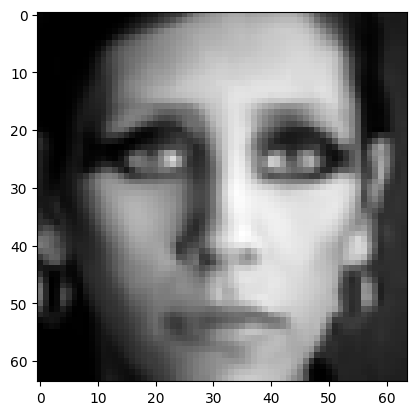

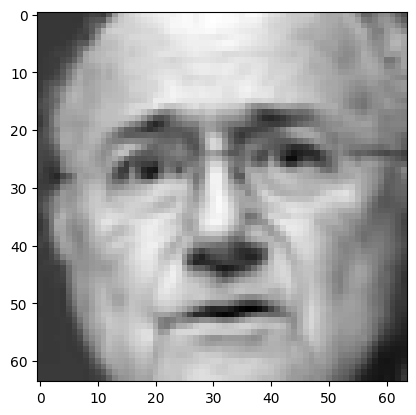

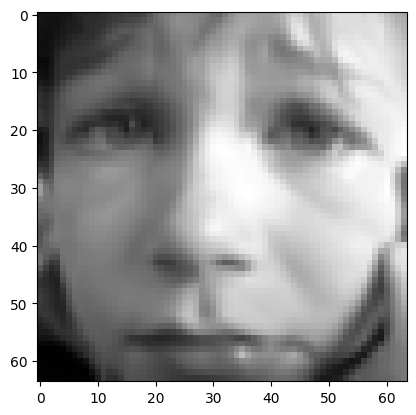

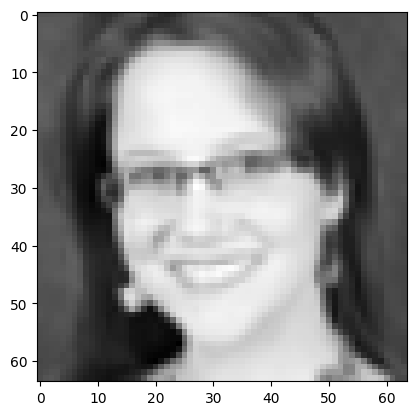

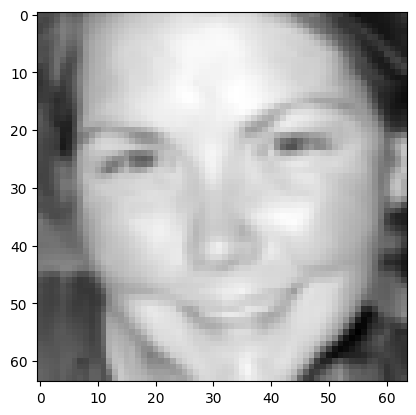

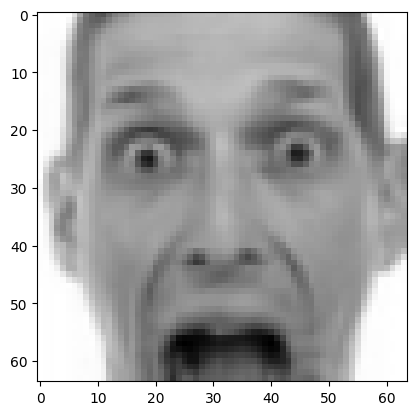

In [ ]:
for i in ds_train_faces[:10]:
  plt.imshow(np.squeeze(i),'gray')
  plt.show()


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras.layers import Flatten, Input, MaxPooling2D, SeparableConv2D
from keras import layers
from keras.regularizers import l2
import keras
from keras.preprocessing import image

# Function to define the model
def emotion_model(input_shape, classes_no):
    input_data = keras.layers.Input(input_shape)
    model = keras.layers.Convolution2D(8, (3,3))(input_data)
    model = keras.layers.BatchNormalization()(model)
    model = keras.layers.Activation('relu')(model)

    my_filters = [16, 64, 256, 512]
    for filter in my_filters:
        model = keras.layers.Convolution2D(filter, (3,3), padding='same')(model)
        model = keras.layers.BatchNormalization()(model)
        model = keras.layers.Activation('relu')(model)
        model = keras.layers.Convolution2D(filter, (3,3), padding='same')(model)
        model = keras.layers.BatchNormalization()(model)
        model = keras.layers.MaxPooling2D(pool_size=(2,2), padding='same')(model)
        model = keras.layers.Activation('relu')(model)

    model = keras.layers.Convolution2D(classes_no, (3,3), padding='same')(model)
    model = keras.layers.GlobalMaxPooling2D()(model)

    ret_model = keras.models.Model(input_data, keras.layers.Activation('softmax', name='predictions')(model))
    return ret_model

# Parameters
input_shape = (64, 64, 1)

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=int(50/4), verbose=1, min_lr=1e-6)

# ModelCheckpoint to save the best model
model_checkpoint = ModelCheckpoint(
    'best_emotion_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [early_stop, reduce_lr, model_checkpoint]

# Data generator
data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

# Model parameters/compilation
model = emotion_model(input_shape, 7)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Loading dataset & training
model.fit(
    data_generator.flow(ds_train_faces, ds_train_emotions, batch_size=32),
    steps_per_epoch=len(ds_train_faces) // 32,
    epochs=100,
    verbose=1,
    callbacks=callbacks,
    validation_data=val_data
)



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 62, 62, 8)           │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 8)           │              32 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 62, 62, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 62, 62, 16)          │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 62, 62, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 31, 31, 64)          │           9,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 31, 31, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 31, 31, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 31, 31, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 16, 16, 256)         │         147,7

 Total params: 4,366,615 (16.66 MB)

 Trainable params: 4,363,207 (16.64 MB)

 Non-trainable params: 3,408 (13.31 KB)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2520 - loss: 1.9309
Epoch 1: val_accuracy improved from -inf to 0.40945, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.2521 - loss: 1.9307 - val_accuracy: 0.4094 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 2/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.2812 - loss: 1.5449

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.40945
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.2812 - loss: 1.5449 - val_accuracy: 0.4064 - val_loss: 1.5391 - learning_rate: 0.0010
Epoch 3/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4410 - loss: 1.4355
Epoch 3: val_accuracy improved from 0.40945 to 0.52605, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.4411 - loss: 1.4354 - val_accuracy: 0.5261 - val_loss: 1.2287 - learning_rate: 0.0010
Epoch 4/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.4375 - loss: 1.4439
Epoch 4: val_accuracy did not improve from 0.52605
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4375 - loss: 1.4439 - val_accuracy: 0.5242 - val_loss: 1.2358 - learning_rate: 0.0010
Epoch 5/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5288 - loss: 1.2413
Epoch 5: val_accuracy improved from 0.52605 to 0.53706, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.5288 - loss: 1.2412 - val_accuracy: 0.5371 - val_loss: 1.1966 - learning_rate: 0.0010
Epoch 6/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5312 - loss: 1.0400
Epoch 6: val_accuracy improved from 0.53706 to 0.53845, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.0400 - val_accuracy: 0.5385 - val_loss: 1.1977 - learning_rate: 0.0010
Epoch 7/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5517 - loss: 1.1658
Epoch 7: val_accuracy did not improve from 0.53845
897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 32ms/step - accuracy: 0.5517 - loss: 1.1658 - val_accuracy: 0.5234 - val_loss: 1.2261 - learning_rate: 0.0010
Epoch 8/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.5312 - loss: 1.5678
Epoch 8: val_accuracy did not improve from 0.53845
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5312 - loss: 1.5678 - val_accuracy: 0.5325 - val_loss: 1.2058 - learning_rate: 0.0010
Epoch 9/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5732 - loss: 1.1174
Epoch 9: val_accuracy improved from 0.53845 to 0.57091, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.5732 - loss: 1.1174 - val_accuracy: 0.5709 - val_loss: 1.1086 - learning_rate: 0.0010
Epoch 10/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.5312 - loss: 1.1357
Epoch 10: val_accuracy did not improve from 0.57091
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.1357 - val_accuracy: 0.5705 - val_loss: 1.1086 - learning_rate: 0.0010
Epoch 11/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6011 - loss: 1.0600
Epoch 11: val_accuracy did not improve from 0.57091
897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.6011 - loss: 1.0600 - val_accuracy: 0.5199 - val_loss: 1.2738 - learning_rate: 0.0010
Epoch 12/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.6250 - loss: 0.8795
Epoch 12: val_accuracy did not improve from 0.57091
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6250 - loss: 0.8795 - val_accuracy: 0.5255 - val_loss: 1.2583 - learning_rate: 0.0010
Epoch 1

897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.6205 - loss: 1.0238 - val_accuracy: 0.5894 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 14/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.5625 - loss: 1.1000
Epoch 14: val_accuracy improved from 0.58944 to 0.58958, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5625 - loss: 1.1000 - val_accuracy: 0.5896 - val_loss: 1.0823 - learning_rate: 0.0010
Epoch 15/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6243 - loss: 0.9958
Epoch 15: val_accuracy improved from 0.58958 to 0.59028, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.6243 - loss: 0.9958 - val_accuracy: 0.5903 - val_loss: 1.0859 - learning_rate: 0.0010
Epoch 16/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.5312 - loss: 1.1949
Epoch 16: val_accuracy improved from 0.59028 to 0.59278, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5312 - loss: 1.1949 - val_accuracy: 0.5928 - val_loss: 1.0806 - learning_rate: 0.0010
Epoch 17/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6328 - loss: 0.9765
Epoch 17: val_accuracy improved from 0.59278 to 0.62901, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.6328 - loss: 0.9765 - val_accuracy: 0.6290 - val_loss: 0.9943 - learning_rate: 0.0010
Epoch 18/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.5312 - loss: 1.1993
Epoch 18: val_accuracy did not improve from 0.62901
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.1993 - val_accuracy: 0.6275 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 19/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6431 - loss: 0.9440
Epoch 19: val_accuracy did not improve from 0.62901
897/897 ━━━━━━━━━━━━━━━━━━━━ 29s 32ms/step - accuracy: 0.6431 - loss: 0.9440 - val_accuracy: 0.6194 - val_loss: 1.0057 - learning_rate: 0.0010
Epoch 20/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.5312 - loss: 1.1836
Epoch 20: val_accuracy did not improve from 0.62901
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5312 - loss: 1.1836 - val_accuracy: 0.6184 - val_loss: 1.0027 - learning_rate: 0.0010
Epoch 2

897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.6705 - loss: 0.8753 - val_accuracy: 0.6335 - val_loss: 0.9665 - learning_rate: 0.0010
Epoch 26/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.6562 - loss: 0.9413
Epoch 26: val_accuracy improved from 0.63346 to 0.63458, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6562 - loss: 0.9413 - val_accuracy: 0.6346 - val_loss: 0.9674 - learning_rate: 0.0010
Epoch 27/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6835 - loss: 0.8501
Epoch 27: val_accuracy improved from 0.63458 to 0.63695, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.6835 - loss: 0.8501 - val_accuracy: 0.6369 - val_loss: 0.9754 - learning_rate: 0.0010
Epoch 28/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.6250 - loss: 0.8885
Epoch 28: val_accuracy did not improve from 0.63695
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 0.8885 - val_accuracy: 0.6349 - val_loss: 0.9814 - learning_rate: 0.0010
Epoch 29/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6913 - loss: 0.8292
Epoch 29: val_accuracy improved from 0.63695 to 0.64628, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.6913 - loss: 0.8292 - val_accuracy: 0.6463 - val_loss: 0.9668 - learning_rate: 0.0010
Epoch 30/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.6250 - loss: 0.9573
Epoch 30: val_accuracy did not improve from 0.64628
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6250 - loss: 0.9573 - val_accuracy: 0.6454 - val_loss: 0.9674 - learning_rate: 0.0010
Epoch 31/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6945 - loss: 0.8135
Epoch 31: val_accuracy did not improve from 0.64628
897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.6945 - loss: 0.8135 - val_accuracy: 0.6456 - val_loss: 0.9684 - learning_rate: 0.0010
Epoch 32/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.7188 - loss: 0.7356
Epoch 32: val_accuracy improved from 0.64628 to 0.65004, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.7356 - val_accuracy: 0.6500 - val_loss: 0.9564 - learning_rate: 0.0010
Epoch 33/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7037 - loss: 0.7867
Epoch 33: val_accuracy did not improve from 0.65004
897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.7037 - loss: 0.7867 - val_accuracy: 0.6404 - val_loss: 0.9758 - learning_rate: 0.0010
Epoch 34/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.7500 - loss: 0.7126
Epoch 34: val_accuracy did not improve from 0.65004
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.7126 - val_accuracy: 0.6407 - val_loss: 0.9762 - learning_rate: 0.0010
Epoch 35/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7080 - loss: 0.7789
Epoch 35: val_accuracy improved from 0.65004 to 0.65102, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.7080 - loss: 0.7789 - val_accuracy: 0.6510 - val_loss: 0.9615 - learning_rate: 0.0010
Epoch 36/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 23s 27ms/step - accuracy: 0.6250 - loss: 0.8701
Epoch 36: val_accuracy did not improve from 0.65102
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6250 - loss: 0.8701 - val_accuracy: 0.6495 - val_loss: 0.9644 - learning_rate: 0.0010
Epoch 37/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7216 - loss: 0.7535
Epoch 37: val_accuracy improved from 0.65102 to 0.65450, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.7216 - loss: 0.7535 - val_accuracy: 0.6545 - val_loss: 0.9316 - learning_rate: 0.0010
Epoch 38/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.7188 - loss: 0.9685
Epoch 38: val_accuracy improved from 0.65450 to 0.65478, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7188 - loss: 0.9685 - val_accuracy: 0.6548 - val_loss: 0.9330 - learning_rate: 0.0010
Epoch 39/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7278 - loss: 0.7194
Epoch 39: val_accuracy improved from 0.65478 to 0.66620, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.7278 - loss: 0.7195 - val_accuracy: 0.6662 - val_loss: 0.9046 - learning_rate: 0.0010
Epoch 40/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.7188 - loss: 0.7173
Epoch 40: val_accuracy improved from 0.66620 to 0.66732, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7188 - loss: 0.7173 - val_accuracy: 0.6673 - val_loss: 0.9009 - learning_rate: 0.0010
Epoch 41/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7366 - loss: 0.7091
Epoch 41: val_accuracy did not improve from 0.66732
897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.7366 - loss: 0.7091 - val_accuracy: 0.6555 - val_loss: 0.9790 - learning_rate: 0.0010
Epoch 42/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.6562 - loss: 0.7835
Epoch 42: val_accuracy did not improve from 0.66732
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6562 - loss: 0.7835 - val_accuracy: 0.6530 - val_loss: 0.9839 - learning_rate: 0.0010
Epoch 43/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7497 - loss: 0.6771
Epoch 43: val_accuracy did not improve from 0.66732
897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.7497 - loss: 0.6772 - val_accuracy: 0.6630 - val_loss: 0.9224 - learning_rate: 0.0010
Epoch 44

897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 34ms/step - accuracy: 0.7553 - loss: 0.6576 - val_accuracy: 0.6718 - val_loss: 0.9283 - learning_rate: 0.0010
Epoch 46/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.7500 - loss: 0.6780
Epoch 46: val_accuracy did not improve from 0.67177
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7500 - loss: 0.6780 - val_accuracy: 0.6718 - val_loss: 0.9286 - learning_rate: 0.0010
Epoch 47/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7576 - loss: 0.6546
Epoch 47: val_accuracy did not improve from 0.67177
897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.7576 - loss: 0.6547 - val_accuracy: 0.6587 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 48/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 23s 26ms/step - accuracy: 0.8750 - loss: 0.6005
Epoch 48: val_accuracy did not improve from 0.67177
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8750 - loss: 0.6005 - val_accuracy: 0.6594 - val_loss: 0.9942 - learning_rate: 0.0010
Epoch 4

897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8002 - loss: 0.5430 - val_accuracy: 0.6730 - val_loss: 0.9859 - learning_rate: 1.0000e-04
Epoch 54/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.8125 - loss: 0.4665
Epoch 54: val_accuracy did not improve from 0.67303
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8125 - loss: 0.4665 - val_accuracy: 0.6726 - val_loss: 0.9863 - learning_rate: 1.0000e-04
Epoch 55/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8210 - loss: 0.4870
Epoch 55: val_accuracy improved from 0.67303 to 0.67888, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.8210 - loss: 0.4870 - val_accuracy: 0.6789 - val_loss: 0.9998 - learning_rate: 1.0000e-04
Epoch 56/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.7812 - loss: 0.4692
Epoch 56: val_accuracy improved from 0.67888 to 0.67916, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7812 - loss: 0.4692 - val_accuracy: 0.6792 - val_loss: 0.9994 - learning_rate: 1.0000e-04
Epoch 57/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8329 - loss: 0.4642
Epoch 57: val_accuracy improved from 0.67916 to 0.68111, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.8329 - loss: 0.4642 - val_accuracy: 0.6811 - val_loss: 1.0028 - learning_rate: 1.0000e-04
Epoch 58/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.6875 - loss: 0.8143
Epoch 58: val_accuracy did not improve from 0.68111
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6875 - loss: 0.8143 - val_accuracy: 0.6811 - val_loss: 1.0028 - learning_rate: 1.0000e-04
Epoch 59/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8360 - loss: 0.4522
Epoch 59: val_accuracy did not improve from 0.68111
897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8360 - loss: 0.4522 - val_accuracy: 0.6772 - val_loss: 1.0014 - learning_rate: 1.0000e-04
Epoch 60/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.9062 - loss: 0.3119
Epoch 60: val_accuracy did not improve from 0.68111
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9062 - loss: 0.3119 - val_accuracy: 0.6778 - val_loss: 1.0020 - learning_rate: 1.

897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.8413 - loss: 0.4366 - val_accuracy: 0.6826 - val_loss: 1.0358 - learning_rate: 1.0000e-05
Epoch 66/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 25s 28ms/step - accuracy: 0.8438 - loss: 0.4210
Epoch 66: val_accuracy did not improve from 0.68264
897/897 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8438 - loss: 0.4210 - val_accuracy: 0.6825 - val_loss: 1.0356 - learning_rate: 1.0000e-05
Epoch 67/100
896/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8453 - loss: 0.4231
Epoch 67: val_accuracy did not improve from 0.68264
897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8453 - loss: 0.4231 - val_accuracy: 0.6817 - val_loss: 1.0405 - learning_rate: 1.0000e-05
Epoch 68/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 28ms/step - accuracy: 0.7812 - loss: 0.6298
Epoch 68: val_accuracy did not improve from 0.68264
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7812 - loss: 0.6298 - val_accuracy: 0.6819 - val_loss: 1.0406 - learning_rate: 1.

897/897 ━━━━━━━━━━━━━━━━━━━━ 39s 33ms/step - accuracy: 0.8500 - loss: 0.4126 - val_accuracy: 0.6836 - val_loss: 1.0467 - learning_rate: 1.0000e-05
Epoch 76/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - accuracy: 0.8750 - loss: 0.3688
Epoch 76: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 76: val_accuracy improved from 0.68362 to 0.68390, saving model to best_emotion_model.h5


897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8750 - loss: 0.3688 - val_accuracy: 0.6839 - val_loss: 1.0467 - learning_rate: 1.0000e-05
Epoch 77/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.8485 - loss: 0.4161
Epoch 77: val_accuracy did not improve from 0.68390
897/897 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.8485 - loss: 0.4161 - val_accuracy: 0.6825 - val_loss: 1.0486 - learning_rate: 1.0000e-06
Epoch 78/100
  1/897 ━━━━━━━━━━━━━━━━━━━━ 24s 27ms/step - accuracy: 0.9062 - loss: 0.2136
Epoch 78: val_accuracy did not improve from 0.68390
897/897 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9062 - loss: 0.2136 - val_accuracy: 0.6829 - val_loss: 1.0489 - learning_rate: 1.0000e-06
Epoch 79/100
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8502 - loss: 0.4105
Epoch 79: val_accuracy did not improve from 0.68390
897/897 ━━━━━━━━━━━━━━━━━━━━ 38s 33ms/step - accuracy: 0.8502 - loss: 0.4105 - val_accuracy: 0.6825 - val_loss: 1.0499 - learning_rate: 1.0

In [ ]:
from google.colab import files
files.download("best_emotion_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
from tensorflow.keras.models import load_model

# Correct model path
model_path = "/content/best_emotion_model.h5"

# Check if the model exists before loading
if os.path.exists(model_path):
    print("✅ Model found. Loading now...")
    model = load_model(model_path)
else:
    raise FileNotFoundError("❌ Model not found! Check the path.")

✅ Model found. Loading now...


In [ ]:

# Evaluate the model
loss, accuracy = model.evaluate(ds_test_faces, ds_test_emotions, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


NameError: name 'ds_test_faces' is not defined

In [ ]:
from keras.models import model_from_json

# Serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model.save_weights("model.weights.h5")
print("Model and weights saved successfully!")


Model and weights saved successfully!


In [ ]:
from keras.models import model_from_json

# Load JSON and create model
with open("model.json", "r") as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json)

# Load weights into the new model
loaded_model.load_weights("model.weights.h5")  # Use the correct filename
print("Model and weights loaded successfully!")

Model and weights loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 78 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image

def detect_face(cascade, pic, scaleFactor=1.3):
    img = pic.copy()

    # Convert image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces using Haar cascade
    face_box = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=5)

    cropped = []
    xs = []
    ys = []

    for (x, y, w, h) in face_box:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Crop and resize face to match model input
        gray_frame = gray_image[y:y + h, x:x + w]
        cropped_img = cv2.resize(gray_frame, (64, 64))  # Resize directly to model size

        # Normalize pixels between 0 and 1 (Assuming the model expects this)
        cropped_img = cropped_img.astype('float32') / 255.0

        # Reshape to match model input: (64, 64, 1)
        cropped_img = np.expand_dims(cropped_img, axis=-1)  # Add channel dimension

        cropped.append(cropped_img)
        xs.append(x)
        ys.append(y)

    return xs, ys, img, cropped


In [ ]:

emotion_lib = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}
test_image=cv2.imread('/jappy2.jpg')

In [ ]:
import glob

# Search for .h5 files in the current directory
h5_files = glob.glob("*.h5")

if h5_files:
    print("Available model files:", h5_files)
else:
    print("No .h5 model files found in this directory!")


Available model files: ['best_emotion_model.h5', 'model.weights.h5']


In [ ]:
from tensorflow.keras.models import load_model

model_path = "best_emotion_model.h5"  # Use the correct file name
loaded_model = load_model(model_path)
print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing import image

from google.colab import files

uploaded = files.upload()

# Load the pre-trained Haar Cascade for face detection
cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Load the trained emotion recognition model
model_path = "best_emotion_model.h5"  # Use the correct file name
loaded_model = load_model(model_path)

# Define emotion labels (Modify based on your model's classes)
emotion_lib = {0: "Happy", 1: "Sad", 2: "Angry", 3: "Neutral"}

def detect_face(cascade, pic, scaleFactor=1.1, minNeighbors=5):
    """Detect faces in an image using Haar Cascade and preprocess them for the model."""
    img = pic.copy()

    # Convert image to grayscale
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detect faces
    face_box = cascade.detectMultiScale(gray_image, scaleFactor=scaleFactor, minNeighbors=minNeighbors)

    # Debugging: Print detected faces
    print(f"Detected {len(face_box)} faces")

    cropped = []
    xs = []
    ys = []

    for (x, y, w, h) in face_box:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Crop the face
        gray_frame = gray_image[y:y+h, x:x+w]

        if gray_frame.size == 0:
            print(f"Skipping empty face at ({x}, {y})")
            continue

        # Resize to (48, 48) first for normalization
        cropped_img = cv2.resize(gray_frame, (48, 48))
        cropped_img = cropped_img.astype('float32') / 255.0  # Normalize pixel values

        # Resize to (64, 64) for model input
        cropped_img = cv2.resize(cropped_img, (64, 64))

        # Expand dimensions to match model input (batch_size, height, width, channels)
        cropped_img = np.expand_dims(cropped_img, axis=-1)
        cropped_img = np.expand_dims(cropped_img, axis=0)

        cropped.append(cropped_img)
        xs.append(x)
        ys.append(y)

    return xs, ys, img, cropped









# Load test image
test_image = cv2.imread('happy.jpg')  # Replace with actual image path







if test_image is None:
    print("Test image not found!")
    exit()

# Detect faces and preprocess them
x, y, face, crop = detect_face(cascade, test_image)

# Display detected faces
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide axes for better display
plt.show()

# Emotion recognition on detected faces
for i in range(len(crop)):
    if crop[i] is None or crop[i].size == 0:  # Check if face is detected
        print(f"Skipping empty face at index {i}")
        continue

    # Predict Emotion
    emotion_pred = int(np.argmax(loaded_model.predict(crop[i])))

    # Annotate Image
    cv2.putText(face, emotion_lib.get(emotion_pred, "Unknown"), (x[i], y[i]),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

# Display Final Image with Predictions
plt.imshow(cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()
